In [59]:
import itertools
import os.path
from mltools.weka import *
from mltools.perfmeasures import * 
from mltools.mltools import * 
import pandas as pd
import seaborn as sns
sns.set_context("talk")
from pylab import * 
%matplotlib inline

## run profkernel

In [27]:
l = 1
y = 3
fraglen = 25
method = "bval"
path = "data/testset{0}.{1}/testset{0}.{1}".format(fraglen, method)

In [28]:
print(">>> Working on parameters L={0}, Y={1}".format(l, y))
!profkernel-core -o {path}.idfile -K -L {l} -Y {y} -i /usr/share/fastprofkernel/data/Amino.txt -g /usr/share/fastprofkernel/data/Globals.txt {path}.kernelinput > {path}_L{l}_Y{y}.mat 2> {path}_L{l}_Y{y}.mat.log

>>> Working on parameters L=1, Y=3


In [29]:
row_count = !wc -l "{path}_L{l}_Y{y}.mat"
row_count = int(row_count[0].split(" ")[0])
row_count

2098

In [30]:
!echo "{row_count} {row_count}\n$(cat {path}_L{l}_Y{y}.mat)" > {path}_L{l}_Y{y}.2.mat

## run weka

In [31]:
## self test 
# !java -Xmx5g -cp bin/wekaTobi.jar:bin/weka.jar: weka.classifiers.meta.CVParameterSelection -p 1 -t {path}.train.arff -T {path}.train.arff -S 1 -W weka.classifiers.functions.SMO -- -C 1.0 -L 0.0010 -P 1.0E-12 -N 0 -V -1 -W 1 -K "weka.classifiers.functions.supportVector.CustomPrecomputedKernelMatrixKernelFast -M data/region25_out/region25_L{l}_Y{y}.2.mat" > {path}.self_L{l}_Y{y}.weka

In [32]:
!java -Xmx5g -cp bin/wekaTobi.jar:bin/weka.jar: weka.classifiers.meta.CVParameterSelection -p 1 -t {path}.train.arff -T {path}.test.arff -S 1 -W weka.classifiers.functions.SMO -- -C 1.0 -L 0.0010 -P 1.0E-12 -N 0 -V -1 -W 1 -K "weka.classifiers.functions.supportVector.CustomPrecomputedKernelMatrixKernelFast -M {path}_L{l}_Y{y}.2.mat" > {path}_L{l}_Y{y}.weka


## get performances

In [63]:
perf_d = {}
stderr_d = {}
for method in ["norsnet", "bval", "ucon"]:
    path = "data/testset{0}.{1}/testset{0}.{1}".format(fraglen, method)
    
    perf_dict = {}
    instances = extract_confusion_matrix_instances("{0}_L{1}_Y{2}.weka".format(path, l, y))
    perfs = bootstrap(instances)
    
    mccs = []
    senss = []
    specs = []
    for perf in perfs: 
        mccs.append(mcc(*perf))
        senss.append(sens(*perf))
        specs.append(spec(*perf))
    perf_d[method] = {"MCC": np.mean(mccs), "Sens.": np.mean(senss), "Spec.": np.mean(specs)}
    stderr_d[method] = {"MCC": stderr(mccs), "Sens.": stderr(senss), "Spec.": stderr(specs)}

In [64]:
perf_df = pd.DataFrame(perf_d)
perf_df

,bval,norsnet,ucon
MCC,0.323737,0.237609,0.373897
Sens.,0.248203,0.160215,0.239578
Spec.,1.000000,0.967686,0.976033


In [65]:
stderr_df = pd.DataFrame(stderr_d)
stderr_df

,bval,norsnet,ucon
MCC,0.000460,0.001485,0.001336
Sens.,0.000554,0.001380,0.001271
Spec.,0.000000,0.000183,0.000164


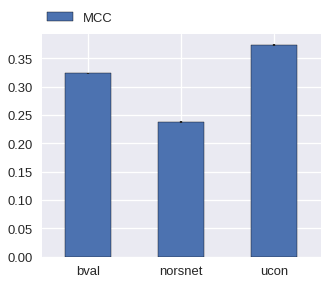

In [91]:
fig, ax = subplots(figsize=(5,4))
pd.DataFrame(perf_df.ix["MCC"]).plot.bar(ax= ax, yerr=pd.DataFrame(stderr_df.ix["MCC"]))
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=0)
legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, borderaxespad=0.)
fig.savefig("pres/img/mcc_testset.pdf")

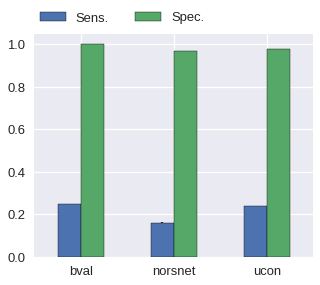

In [93]:
fig, ax = subplots(figsize=(5,4))
perf_df.loc[["Sens.", "Spec."]].transpose().plot.bar(ax= ax, yerr=stderr_df.loc[["Sens.", "Spec."]].transpose())
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=0)
legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, borderaxespad=0., ncol=2)
fig.savefig("pres/img/sens_spec_testset.pdf")